In [38]:
from scipy.io import wavfile
import scipy.fftpack
from matplotlib import pyplot as plt
import numpy as np
import random as r
import os
import re

In [2]:
samplerate = 48000
##output location
filepath = '/Library/Audio/Samples/Impulse Responses/DIY/DIY-IR/'
for i in sorted(os.listdir(filepath)):
    if not i.startswith('.'): ##exclude hidden files
        print(i)

1.wav
10sinusoid.wav
11sinusoid.wav
12sinusoid.wav
13sinusoid.wav
14sinusoid.wav
15sinusoid_truncated.wav
16noise_sinusoid.wav
17noise_sinusoid.wav
18noise_sinusoid.wav
19noise_sinusoid.wav
1_decreasing.wav
1_increasing.wav
20noise_sinusoid_squarified.wav
21linear_sinusoid_truncated_squarified.wav
22linear_sinusoid_truncated_squarified.wav
2_decreasing.wav
3.wav
4.wav
5_descending.wav
6.wav
7linear.wav
8log_log.wav
9log.wav


## Displays

In [3]:
def show_signal(signal):
    ##Converts x axis from samples to seconds
    x = [(i/samplerate) for i in range(len(signal))]
    plt.plot(x, signal)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (seconds)')
    plt.show()
    
def show_freqs(signal):
    N = len(signal)
    halfN = int(N/2)
    T = 1 / samplerate
    x = np.linspace(0.0, N*T, N)
    y = signal
    yf = scipy.fftpack.fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), halfN)
    plt.subplot(2, 1, 2)
    plt.plot(xf[1:], 2.0/N * np.abs(yf[0:halfN])[1:])
    plt.show()

## Generators

In [23]:

def makenoise(length):
    global signaltype
    signaltype.append('noise')
    noise = []
    for i in range(length):
        noise.append(r.randint(-32768, 32767)/32767)

    noise_info = {'max': max(noise), 'min': min(noise), 'mean': (sum(noise)/len(noise))}
    #for i in noise_info.keys():
    #    print(i, noise_info[i])
    #show_signal(noise)
    #show_freqs(noise)
    return noise

def makelinear(length, ascending=False):
    global signaltype
    signaltype.append('linear')
    line = []
    for i in range(length):
        line.append((2*(length-i)/length)-1)
    if ascending:
        line = sorted(line)
    #show_signal(line)
    #show_freqs(line)
    return line

def makelog(length, base=10, reverse=False):
    global signaltype
    signaltype.append('log')
    logline = []
    for i in range(0, length):
        if i == 0:
            i += .001
        log = np.log(i)/np.log(base)
        logline.append((log/base/2)-1)
    if reverse:
        logline = sorted(logline, reverse=True)
    #show_signal(logline)
    #show_freqs(logline)
    return logline

def makesine(length, intensity=100, hz=100):
    global signaltype
    signaltype.append('sinusoid')
    sine = []
    for i in range(length):
        freq = hz/samplerate
        sine.append(np.cos(i*freq)*(intensity/100))
    #show_signal(sine)
    #show_freqs(sine)
    return sine

## Filtering

In [24]:
def squarify(signal, hz=50):
    new_signal = []
    freq = int(samplerate/hz)
    for i in range(len(signal)):
        if i > freq and i // freq % 2 == 0:
            new_signal.append(0)
        else:
            new_signal.append(signal[i])
    signaltype.append('squarified')
    return new_signal
            
def truncate(signal, threshold=75):
    new_signal = []
    for i in range(len(signal)):
        if abs(signal[i]) > threshold/100:
            new_signal.append(threshold/100 * ([-1,1][int(signal[i]>0)]))
        else:
            new_signal.append(signal[i])
    signaltype.append('truncated')
    return new_signal

## Signal Creator

In [25]:
def make_impulse(generators, seconds=1, combination='add', trunc=100, square=0):
    length = int(seconds*samplerate)
    global signaltype
    gen_list = ['noise','line', 'line_rev','log','log_rev','sine-amp-hz']
    signaltype = []
    signal = {}
    for i in generators:
        if i == 'noise':
            signal[i] = makenoise(length)
        elif i == 'line':
            signal[i] = makelinear(length)
        elif i == 'line_rev':
            signal[i] = makelinear(length, ascending=True)
        elif i == 'log':
            signal[i] = makelog(length)
        elif i == 'log_rev':
            signal[i] = makelog(length, reverse=True)
        elif 'sin' in i:
            parts = i.split('-')
            if len(parts) > 1:
                amplitude = int(parts[1])
                freq = int(parts[2])
                signal[i] = makesine(length, intensity=amplitude, hz=freq)
            else:
                signal[i] = makesine(length)
    out = []
    if combination == 'add':
        for i in range(length):
            out.append(sum([signal[j][i] for j in signal.keys()])/len(signal.keys()))
    if combination == 'multiply':
        for i in range(length):
            out.append(np.prod([signal[j][i] for j in signal.keys()]))
        top = max(out)
        for i in range(len(out)):
            out[i] = out[i]/top
    if combination == 'divide':
        for i in range(length):
            out.append(signal[[i for i in signal.keys()][0]][i] * np.prod(([(signal[j][i]+(int(signal[j][i]==0)/1000))**-1 for j in signal.keys()])))
        top = max(out)
        for i in range(len(out)):
            out[i] = out[i]/top
    if trunc<100:
        out = truncate(out, threshold=trunc)
    if square > 0:
        out = squarify(out, hz=square)
    show_signal(out)
    show_freqs(out)
    return out

## Output

In [26]:
def save_wav(signal):
    most_recent_file_num = max([int(i) for i in re.findall('\d+', "".join(os.listdir(filepath)))])
    filename = str(most_recent_file_num + 1) + "_".join(signaltype) + '.wav'
    signal = np.array(signal)
    wavfile.write(filepath+filename, samplerate, signal)

## Randomization

In [36]:
options = {'generators': ['noise','line', 'line_rev','log','log_rev','sine-amp-hz'],
          'combination': ['add', 'multiply', 'divide']}
def rand_sin():
    return 'sin-' + str(r.randint(50, 100)) + '-' + str(r.randint(2, 20000))

def impulsive():
    trunc_range = [i+(70*int(r.randint(0, 100)>20)) for i in range(1, 30)]
    if r.randint(0,100) > 50:
        trunc_range = [100]
    gens = []
    for i in range(1, r.randint(2,len(options['generators']))):
        gens.append(options['generators'][r.randint(0,len(options['generators'])-1)])
    for i in range(len(gens)):
        if 'sin' in gens[i]:
            gens[i] = rand_sin()
    #print(gens)
    signal = make_impulse(gens, seconds=(r.randint(1,5)*.25), combination=r.choice(options['combination']), trunc=r.choice(trunc_range), square=r.randint(2,5000))
    print(signaltype)
    save_wav(signal)

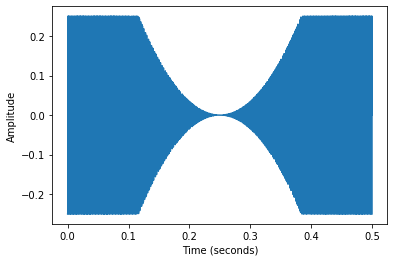

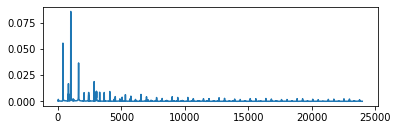

['log', 'sinusoid', 'linear', 'log', 'linear', 'truncated', 'squarified']


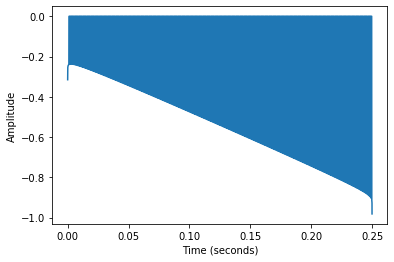

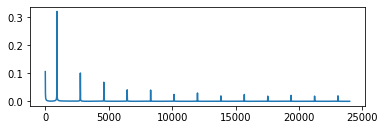

['log', 'linear', 'log', 'log', 'log', 'squarified']


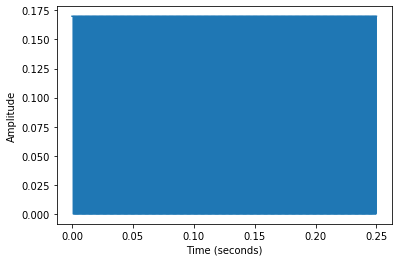

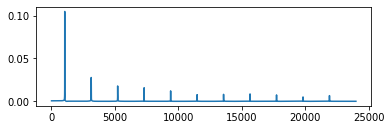

['log', 'truncated', 'squarified']


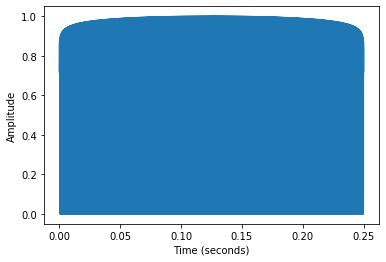

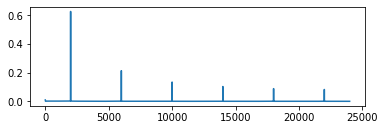

['linear', 'log', 'log', 'linear', 'squarified']


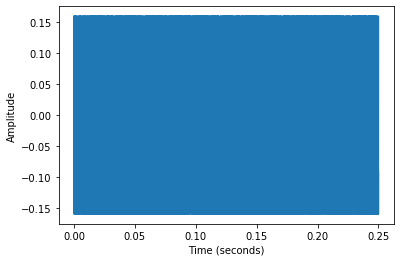

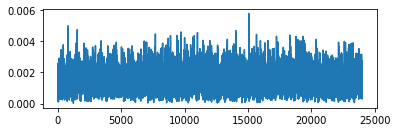

['sinusoid', 'log', 'log', 'noise', 'truncated', 'squarified']


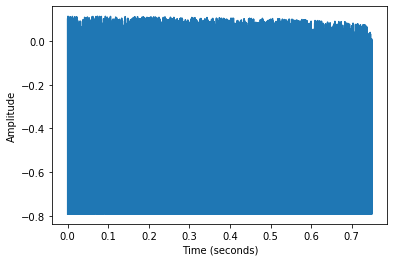

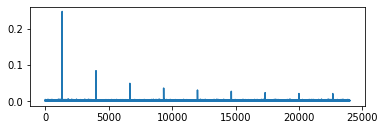

['noise', 'noise', 'log', 'log', 'truncated', 'squarified']


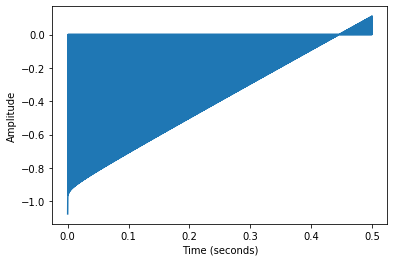

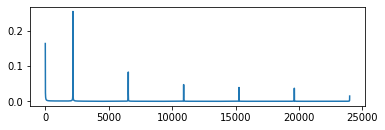

['log', 'linear', 'log', 'squarified']


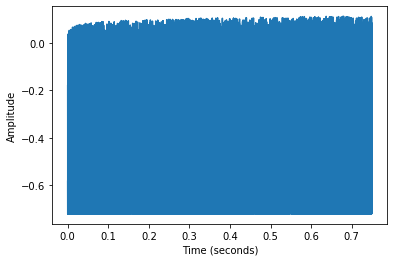

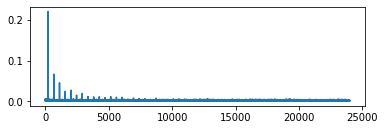

['noise', 'noise', 'log', 'log', 'truncated', 'squarified']


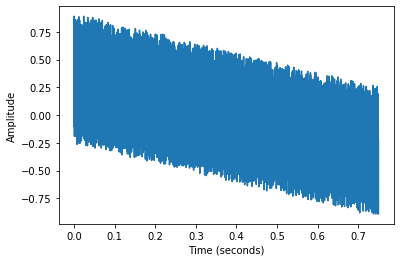

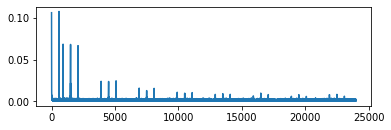

['sinusoid', 'linear', 'noise', 'truncated', 'squarified']


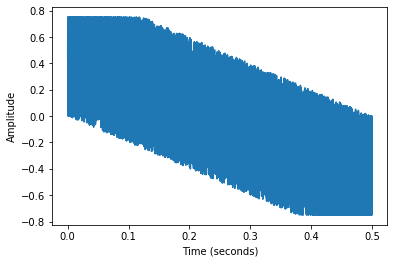

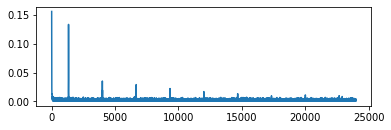

['linear', 'noise', 'truncated', 'squarified']


In [37]:
for i in range(10):
    impulsive()